In [1]:
import itertools
import random

%matplotlib inline
import networkx as nx


# 第5章

目次：

1. [Python の `random` モジュール](#1.-Python&#39;s-random-module)
2. [ランダムネットワークモデル](#2.-Random-Network-Model)
3. [スモールワールドモデル](#3.-Small-World-Model)
4. [優先的選択モデル](#4.-Preferential-Attachment-Model)

このチュートリアルで紹介する各モデルについて、モデルを生成するためのアルゴリズム、実装例、および対応する NetworkX を利用するコードを紹介する。このチュートリアルで提供される実装は、効率化のためではなく、わかりやすさのために書かれている。そのため、実際の分析作業を行う場合は、NetworkX 関数を使用することをお勧めしたい。



## 1. Python の`random`モジュール

多くのネットワークモデルは、生成アルゴリズムのランダム性に依存している。Python の [random](https://docs.python.org/3.7/library/random.html) モジュールは、ネットワークモデルをコーディングする際に使用される 4 つの主要な関数を提供している。

###  `random.random`

アルゴリズムでは、ある確率 $p$ で何かが起こる場面がよくある。そのようなイベントが発生するかどうかを決定する標準的な方法は、0 と 1 の間の乱数 $r$ を生成することである。$r < p$ の場合、イベントが発生しする。 [random.random()](https://docs.python.org/3.7/library/random.html#random.random) 関数は、間隔 $[0, 1)$ でちょうどその需要に応じたな乱数を返す。

簡単な例として、75% の確率で表が出るアンフェア・コインを挙げたい。次のコードを記述して、そのようなコインを 10 回投げ、毎回結果を報告する。


In [2]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Tails
Heads
Tails
Heads
Heads
Heads
Tails
Tails
Heads
Heads



ランダムなプロセスから予想されるように、前のセルを再度実行すると、異なる一連のフリップが生成される。それぞれが個別に生成される。

###  `random.choice`

個別の選択肢の母集団があり、そのうちの 1 つをランダムに選択する必要がある場合は、 [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice) を使用する。例えば、下に示したように、「[eeny、meeny、miny、moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)」の代わりに、 `random.choice` を使用してランダムに名前を選択する。


In [3]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Alice'


### `random.sample`

コレクションがあり、置換せずに複数の要素を選択する必要がある場合は、[random.sample()](https://docs.python.org/3.7/library/random.html#random.sample) を使用する。たとえば、グラフ内のノードからランダムに 2 つのノードを選択するには、次のコードを使用する。


In [4]:
G = nx.cycle_graph(5)
random.sample(G.nodes, 2)

[1, 2]


### `random.choices`

各要素を選択する可能性が同じでない場合に、コレクションから要素を選択したい場合は、[random.choices()](https://docs.python.org/3.7/library/random.html#random.choices)を使用する。

たとえば、Alice、Bob、Carol がくじ引きに参加しているとする。アリスは 1 枚、ボブは 3 枚、キャロルは 4 枚のチケットを購入した。このくじの10通りの抽選をシミュレートし、毎回抽選されたチケットを入れ替えるには、次のコードを使う。


In [5]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

['Carol']
['Alice']
['Carol']
['Carol']
['Carol']
['Alice']
['Bob']
['Bob']
['Carol']
['Carol']



上記のセルを実行すると、予想どおりの結果が得られるはず。Carol が最も頻繁に抽選に当選し、Bob が何度か当選し、Alice がときどき当選する。もちろん、この結果はくじの運次第です！

キーワード引数 `k=` を指定することで、 *交換ありで*コレクションから *k* 個のアイテムを選択できる。


In [6]:
random.choices(names, tickets, k=10)

['Alice',
 'Alice',
 'Bob',
 'Carol',
 'Carol',
 'Carol',
 'Bob',
 'Alice',
 'Bob',
 'Carol']


`random.choices` に提供される重みは必ずしも整数とは限らなく、数値である限り問題はない。



## 2. ランダムネットワークモデル

Gilbert によって定式化されたランダムネットワークモデルには、ノード数 $N$ とリンク確率 $p$ の 2 つのパラメーターがある。本書のテキストのように、このネットワークを作成するためのアルゴリズムは次の手順：

1. ノードのペア、たとえば i と j を選択する
2. 0 から 1 の間の乱数 r を生成します。r < p の場合、i と j の間にリンクを追加する
3. すべてのノードペアに対して (1) と (2) を繰り返す

このタスクには、Python のいくつかのツールが必要である

### 組み合わせの生成

以前は、グラフのすべてのノードやすべてのエッジをループ処理したが、このアルゴリズムでは、ノードのすべての*ペア*、つまりすべての可能なエッジをループ処理する必要がある。 Python の標準ライブラリの `itertools` モジュールには、一連の要素のペアをループする洗練された方法である、[combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) 関数がある。


In [7]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]


`itertools.combinations()` の 2 番目の引数は、出力に必要なシーケンスの長さである。ペアが必要なので、2 を指定する。出力の優れた性質：

1. 繰り返し要素はない。`('a', 'a')` のような自己ループは考慮しない。
2. ペアはソートされた順序になっている。無向グラフの文脈で `('a', 'b')` と `('b', 'a')` は同じエッジであるため、ちょうどこの性質に満たす。

に注意させたい。したがって、これを使用して、グラフ内のすべてのノードペアをループできる。


In [8]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]


### Gilbert ランダムグラフモデル

ツールボックスのこれらのツールを使用して、Gilbert ランダムグラフモデルのアルゴリズム作ることができる。


In [9]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G


この関数を使用すれば所定の手順でグラフを生成できる。ランダムなアルゴリズムであるため、実行するたびに異なるグラフが生成される。


Graph has 15 edges.


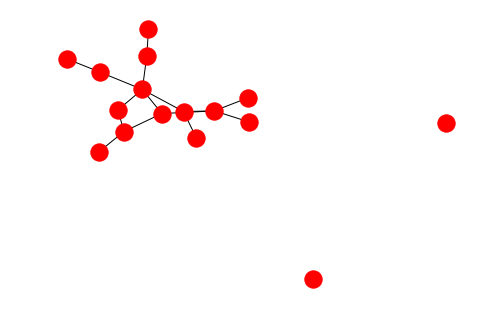

In [10]:
G = gnp_random_graph(16, 0.15)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')


上記のセルを数回実行すると、同じパラメーターで生成されたランダム グラフ間でエッジの数がわずかに異なることに注意させたい。これは、ノードの各ペアがエッジになる可能性が独立であるためである。



### Erdös-Rényi ランダムグラフモデル

リンク確率 $p$ を指定する代わりに、 `random.sample()` を使用して `itertools.combinations()` で生成された可能なエッジの M を選択することにより、ちょうど $M$ 個のエッジを持つ $N$ 個のノードのグラフを生成することもできる。


In [11]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

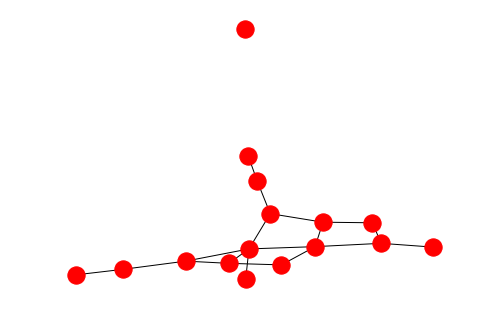

In [12]:
G = gnm_random_graph(16, 18)
nx.draw(G)


### NetworkX の関数

NetworkX には、ノード数 $N$ とリンク確率 $p$ を指定する $G_{n,p}$ ランダムグラフの関数 [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html) が提供される。

さらに、NetworkX は $G_{n,m}$ グラフを生成する [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html) を提供する。ここで、ノード数 $N$ と必要なエッジ数 $M$ を指定する必要がある。



## 3. スモールワールドモデル

スモールワールドネットワークを生成するアルゴリズムは

1. $N$ 個のノードの環状ネットワークから始める
2. 各ノードをその $k$ (k が奇数の場合は $k-1$) 個の最近傍のノードに繋ぐ
3. 各エッジ $(u, v)$ について、確率 $p$ で、エッジ $(u, v)$ を $(u, w)$ に置き換える。ただし、$w$ は $u$ の近傍以外のランダムに選ばれたノードである。

で述べられる。

まずこの手順をステップバイステップで実行し、最後に関数として結合したい。

###  N 個のノードの環

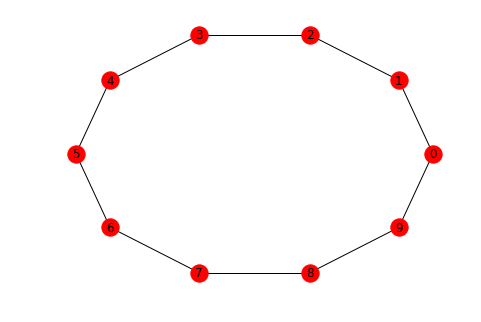

In [13]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)


### 各ノードとその $k$-最近傍に繋ぐ

これを行うためにモジュラ演算を使用する。理由として、例えば、$k$ が 4 であるとする。ノード $n$ の場合、$n$ とその 4 つの最近傍：$n-1$、$n+1$、$n-2$ および $n+2$　の間にエッジを作る。ノードは環の中にあるため、これらは「ラップ・アラウンド」できる。*例えば*、ノード $0$ の 4 つの最近傍は $N-1$、$1$、$N-2$、および $2$ である。

以下の整数除算 (//) の使用に注意させたい。整数除算は、除算の小数部分を捨てる演算である。例えば、

    5 // 2 = 2

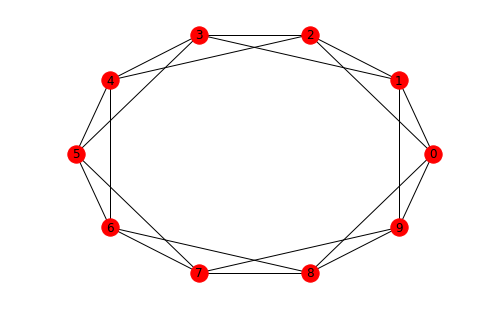

In [14]:
k = 4

for n in G.nodes:
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True)


### エッジを置き換える

>  各エッジ $(u, v)$ について、確率 $p$ で、エッジ $(u, v)$ を $(u, w)$ に置き換える。ただし、$w$ は $u$ の近傍以外のランダムに選ばれたノードである。

このステップでは、集合演算を使用して $u$ の隣接ノードでないノードのリストを生成し、 `random.choice` を使用してその「隣接しない」セットからランダムに $w$ を選択する。


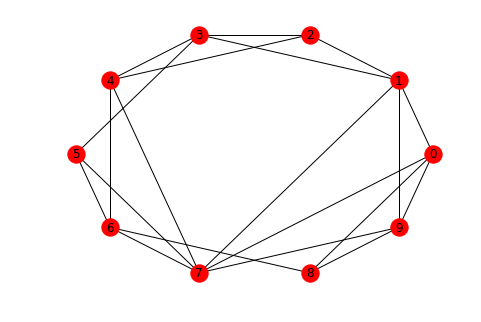

In [15]:
p = 0.1

for u, v in list(G.edges):
    if random.random() < p:
        not_neighbors = set(G.nodes) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True)


### Watts-Strogatz スモールワルドモデル

これをまとめて、スモールワールドモデルの基本的な関数を記述できる。


In [16]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

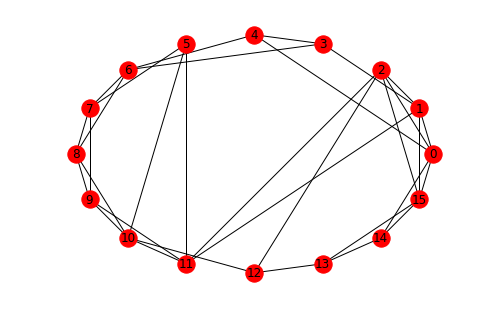

In [17]:
G = watts_strogatz_graph(16, 4, 0.2)
nx.draw_circular(G, with_labels=True)


### NetworkX 関数

NetworkX には、このモデル用の関数 [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html) がある。



## 4. 優先的選択モデル

Barabási-Albert 優先的選択（Preferential Attachment）モデルには、ノードの数 $N$ と、各ステップで追加されるリンクの数 $m$ の 2 つのパラメーターがある。これらのパラメータが与えられると、アルゴリズムは：

1. $m + 1$ ノードの任意のグラフから始める
2. 次数によって重み付けされた $m$ 個の異なるノードをランダムに選択する
3. 新しいノード $i$ を追加し、前のステップの $m$ 個のノードにエッジでリンクする
4. グラフに N 個のノードが存在するまで、2 ～ 3 を繰り返す

一見、このコードは簡単が、テップ 3 では、ランダムな選択に重みを付ける*次数シーケンス*を生成する必要がある。グラフ `G` がある場合、次のようにリスト内包表記を使用して次数列を生成できる。

[4, 1, 1, 1, 1]


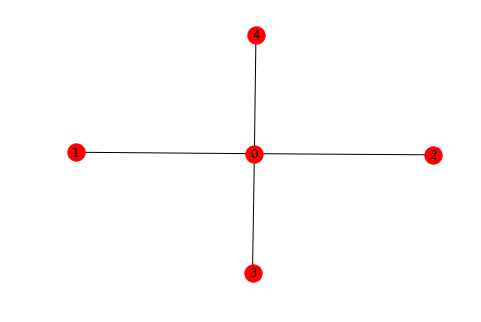

In [18]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw(G, with_labels=True)


次数シーケンスはノードと同じ順序で出力されることに注意させたい。そのため、そのリストのインデックス $i$ のノードは、対応する次数シーケンスのインデックス $i$ の次数を持つ。これにより、BA優先的選択モデルの関数は以下のように実装できる。

In [19]:
def barabasi_albert_graph(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes)
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

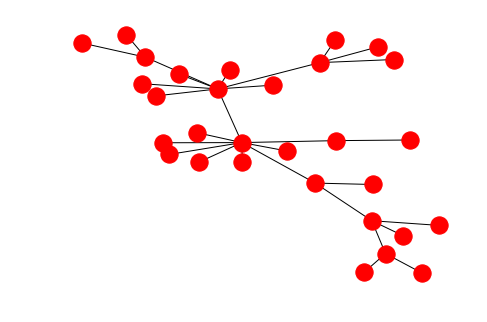

In [20]:
G = barabasi_albert_graph(30, 1)
nx.draw(G)


先ほどの`preferential_attachment_graph`のコードで、ステップ 2 を単に
```
new_neighbors = random.choices(G.nodes, degrees, k=m)
```
というより簡単な書き方を用いらないことに疑問を抱いているかもしれない。それは `random.choices` に $k > 1$ を指定すると、選択が交換ありで行われるためである。つまり、同じノードがリストから複数回選択される可能性がある。ノード $i$ と結合する $m$ 個の異なるノードを選択するには、より複雑なコードが必要である。

###  NetworkX 関数

今まで紹介したすべてのグラフモデルと同様に、NetworkX には BA モデルを生成する関数 [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html) がある。
